## Imports

In [56]:
import os
import sys
sys.path.append("../")

import pandas as pd
import numpy as np
import xarray as xr

import jax
import jax.numpy as jnp
from jax.flatten_util import ravel_pytree

# please import OmegaConf from the hydra package
from omegaconf import OmegaConf

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import GPy

from my_nn import SIREN, fit
from my_utils import pool_image, get_coords_for_image, rmse_fn

import matplotlib.pyplot as plt
from multiprocessing import Pool

## Config

In [57]:
config = {
    "seed": 5,
    "month": "6",
    "features": sorted(["longitude", "latitude"]),
    "target": "PM2.5",
    "test_size": 0.2,
    "val_size": 0.2,
    "layers": [256, 256, 256, 256],
    "activation_scale": 30.0,
    "iterations": 1000,
    "batch_size": -1,
    "lr": 1e-3,
    "gpu_id": 1,
}

## Load data

In [58]:
aq_data = xr.open_dataset("../processed_data/delhi_cpcb_2022_cleaned.nc")
aq_df = aq_data.to_dataframe().reset_index().set_index("time")

## Data selection and processing

In [59]:
useful_df = aq_df[f"2022-{config['month'].zfill(2)}"]
time_stamp = useful_df.sample(1, random_state=config["seed"]).index[0]
print(f"Time stamp: {time_stamp}")

training_df = useful_df[useful_df.index == time_stamp].dropna()
training_df.shape

Time stamp: 2022-06-27 20:30:00


 /tmp/ipykernel_837567/2346640113.py:1: FutureWarning:Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.


(15, 24)

## Train, val, test split

In [60]:
x = training_df[config["features"]].values
y = training_df[[config["target"]]].values

train_val_x_, test_x_, train_val_y_, test_y_ = train_test_split(x, y, test_size=config["test_size"], random_state=config["seed"])
train_x_, val_x_, train_y_, val_y_ = train_test_split(train_val_x_, train_val_y_, test_size=config["val_size"], random_state=config["seed"])
x_scaler = MinMaxScaler((-1, 1))
y_scaler = StandardScaler()
train_x = x_scaler.fit_transform(train_x_)
val_x, test_x = map(x_scaler.transform, (val_x_, test_x_))
train_y = y_scaler.fit_transform(train_y_)
val_y, test_y = map(y_scaler.transform, (val_y_, test_y_))
print(train_x.shape, val_x.shape, test_x.shape, train_y.shape, val_y.shape, test_y.shape)

(9, 3) (3, 3) (3, 3) (9, 1) (3, 1) (3, 1)


## Training

In [61]:
model = SIREN(n_hidden_layer_neurons=config["layers"], output_shape=y.shape[-1], activation_scale=config["activation_scale"])
# Run it with a separate process
def local_fit():
    os.environ["CUDA_VISIBLE_DEVICES"] = str(config["gpu_id"])
    return jax.device_get(fit(jax.random.PRNGKey(config["seed"]), model, train_x, train_y, config["lr"], config["batch_size"], config["iterations"], val_x, val_y, test_x, test_y))
params, old_params_history, train_losses, val_losses, test_losses = Pool(1).apply(local_fit)

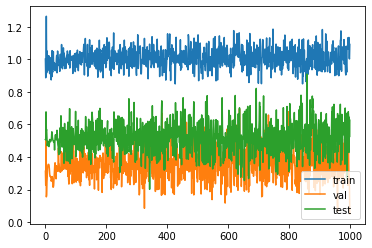

In [62]:
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.plot(test_losses, label="test")
plt.legend();

In [63]:
result_df = pd.DataFrame(columns=["train_loss", "val_loss", "test_loss"])

In [64]:
ii = np.argmin(val_losses)
best_params = jax.tree_map(lambda param: param[ii], old_params_history)
print(f"Best epoch: {ii}, best_train_loss: {train_losses[ii]}, best val loss: {val_losses[ii]}, best test loss: {test_losses[ii]}")
result_df.loc["SIREN", :] = [train_losses[ii], val_losses[ii], test_losses[ii]]
result_df

Best epoch: 999, best_train_loss: 1.0922361612319946, best val loss: 0.049979425966739655, best test loss: 0.6262151002883911


,train_loss,val_loss,test_loss
SIREN,1.092236,0.049979,0.626215


In [65]:
# def test_fn():
#     return jax.device_get(model.apply(best_params, test_x))
# pred_y = Pool(1).apply(test_fn)
# print(f"RMSE: {rmse_fn(pred_y, test_y)}")

In [66]:
model = RandomForestRegressor(n_estimators=1000).fit(train_x, train_y.ravel())
pred_y = model.predict(test_x).reshape(-1, 1)
pred_train_y = model.predict(train_x).reshape(-1, 1)
pred_val_y = model.predict(val_x).reshape(-1, 1)
print(f"train RMSE for random forest: {rmse_fn(pred_train_y, train_y)}")
print(f"val RMSE for random forest: {rmse_fn(pred_val_y, val_y)}")
print(f"test RMSE for random forest: {rmse_fn(pred_y, test_y)}")
result_df.loc["RandomForest", :] = [rmse_fn(pred_train_y, train_y), rmse_fn(pred_val_y, val_y), rmse_fn(pred_y, test_y)]
result_df

train RMSE for random forest: 0.4752591387138311
val RMSE for random forest: 0.17020445237426737
test RMSE for random forest: 0.31590927749682146


,train_loss,val_loss,test_loss
SIREN,1.092236,0.049979,0.626215
RandomForest,0.475259,0.170204,0.315909


## GP

In [67]:
gp = GPy.models.GPRegression(train_x, train_y, GPy.kern.Matern32(train_x.shape[-1], ARD=True))
gp.optimize_restarts(3)

pred_y = gp.predict(test_x)[0]
pred_train_y = gp.predict(train_x)[0]
pred_val_y = gp.predict(val_x)[0]
print(f"GP, train RMSE: {rmse_fn(pred_train_y, train_y)}, val RMSE: {rmse_fn(pred_val_y, val_y)}, test RMSE: {rmse_fn(pred_y, test_y)}")
result_df.loc["GP", :] = [rmse_fn(pred_train_y, train_y), rmse_fn(pred_val_y, val_y), rmse_fn(pred_y, test_y)]
result_df

Optimization restart 1/3, f = 12.656952155077633
Optimization restart 2/3, f = 12.656952026297194
Optimization restart 3/3, f = 12.656952027853595
GP, train RMSE: 9.876451797315297e-08, val RMSE: 0.3082331705417373, test RMSE: 0.33467217944707844


,train_loss,val_loss,test_loss
SIREN,1.092236,0.049979,0.626215
RandomForest,0.475259,0.170204,0.315909
GP,0.0,0.308233,0.334672
